In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
# torch.set_grad_enabled(False)

In [3]:
import optics
import tools

In [4]:
l = 0.5e-3 # mm 
k = 2*torch.pi / l

N = 2500
size = 30 # mm

In [5]:
d, x, y, kx, ky = optics.init_space(size, N)

In [6]:
usaf = cv2.imread("/home/vasily/Projects/diffractsim/examples/apertures/USAF_test.png")[:, :, 0]
usaf_mod = cv2.GaussianBlur(cv2.resize(usaf, (len(x), len(y)))/255, ksize=(31, 31), sigmaX=2)
usaf_mod_t = torch.Tensor(  usaf_mod  ).cuda()


rnd = optics.multi_mode_grf_phase_shift(
    [
        (50/d, torch.pi*4),
        (1/d, torch.pi*0.0)
    ], len(x)
)
with torch.no_grad():
    TR = torch.exp(torch.pi*1j*usaf_mod_t).cuda()* rnd * (1 - usaf_mod_t*0.0)


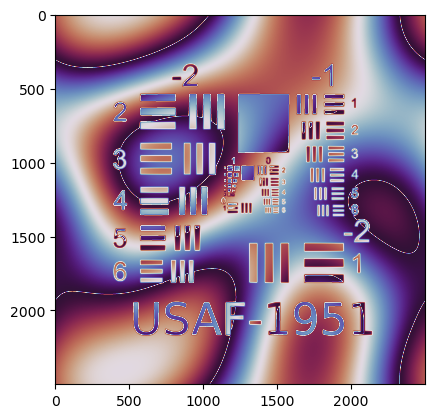

In [7]:
plt.imshow(torch.angle(TR).cpu(), cmap="twilight_shifted")
# plt.imshow(torch.norm(tools.compute_phase_gradient(TR), dim=0).cpu())

In [52]:
sigma = 0.01

In [154]:
alpha = 1/100
kr = k * alpha #
kr

125.66370614359172

In [155]:
led_sep = 4 # mm
led_distance = 800 # mm

In [171]:
def propagate(U0, TR, z=0):
    U1 = U0 * TR
    A1 = torch.fft.fft2(U1)
    Ar = A1 * optics.Hz(z, k, kx, ky) * ( ( ((kx)**2 + ky**2) < kr**2))
    Ur = torch.fft.ifft2(Ar)
    return Ur

In [172]:
def source( led_x, led_y):
    U0 = optics.cringe_source(sigma, kx0=led_x *k * led_sep/led_distance, ky0=led_y*k * led_sep/led_distance, kx=kx, ky=ky)
    return U0

/tmp/ipykernel_311185/2195482052.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


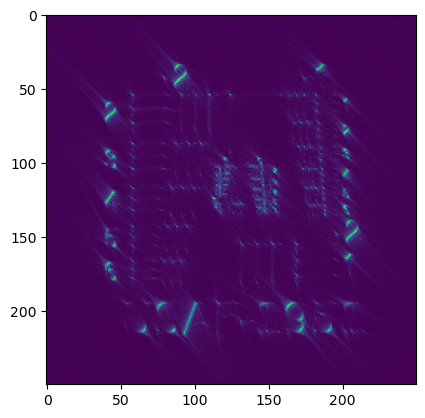

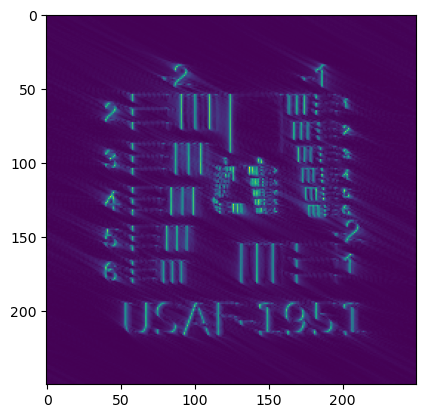

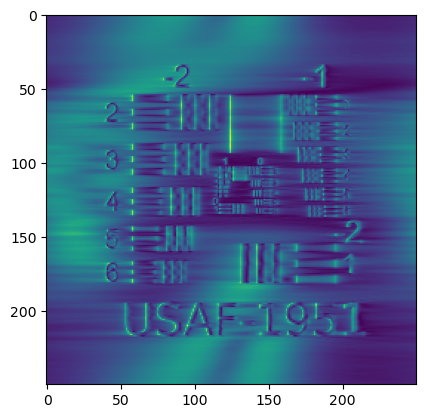

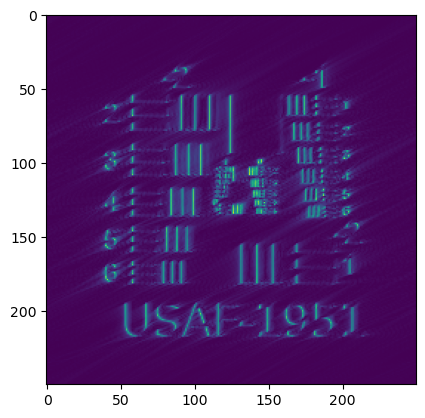

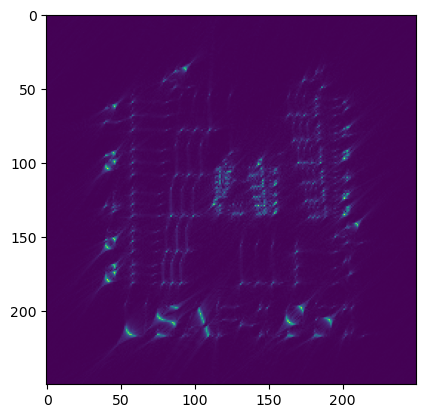

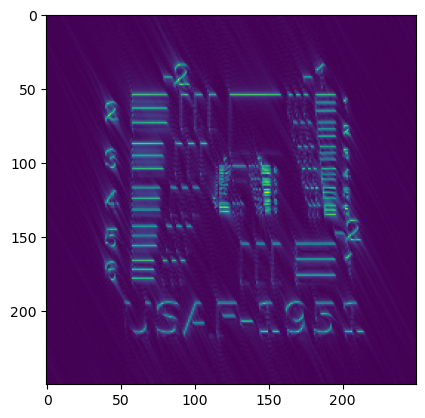

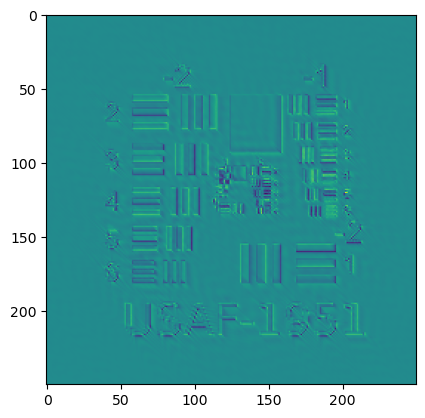

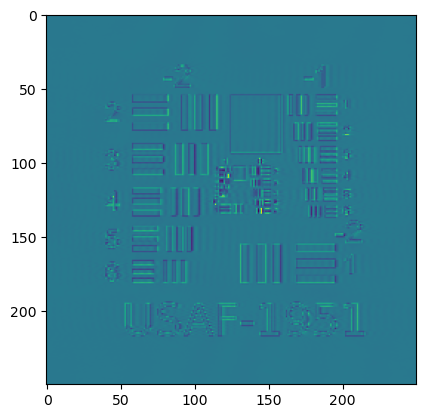

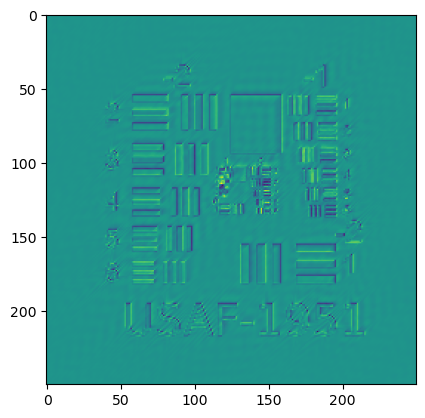

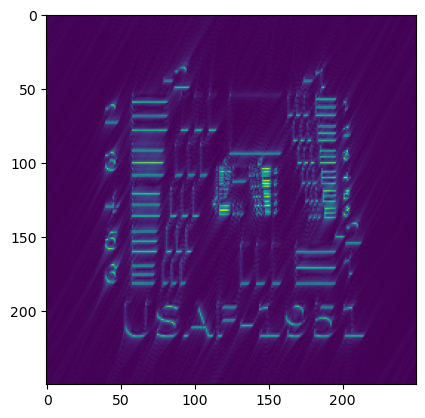

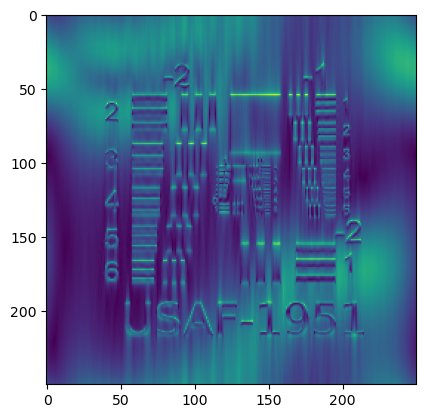

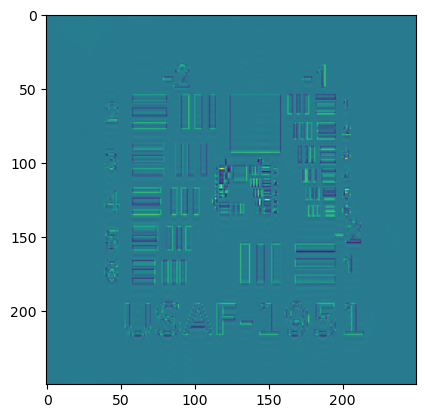

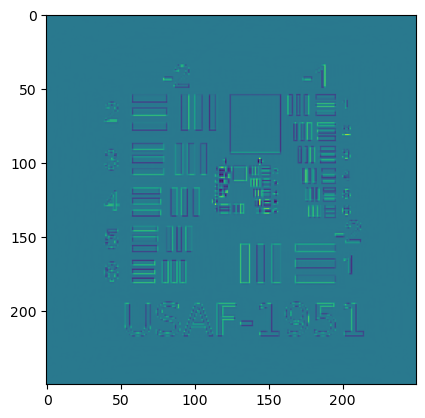

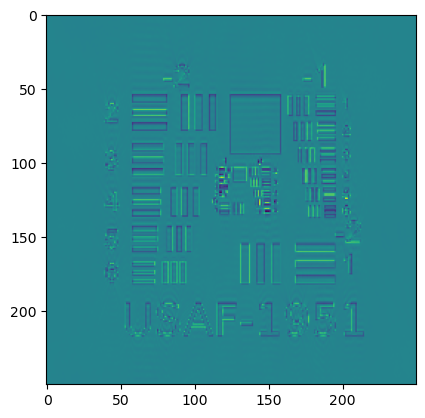

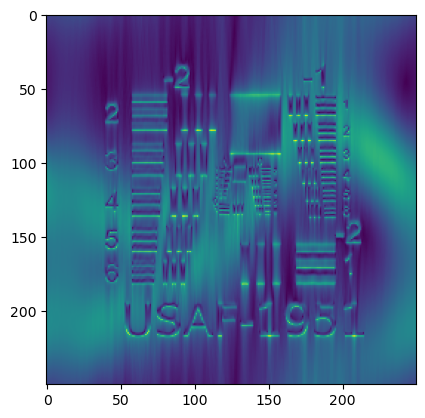

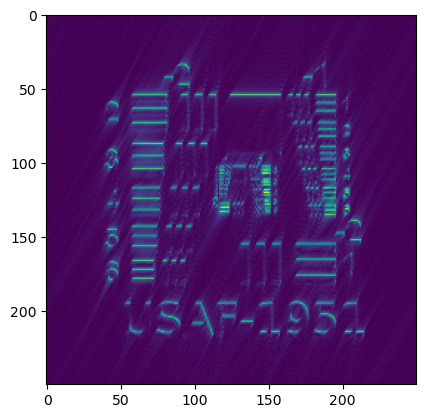

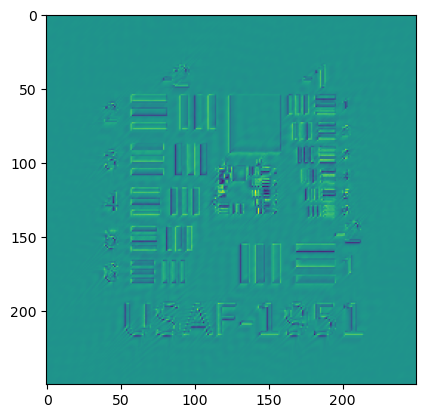

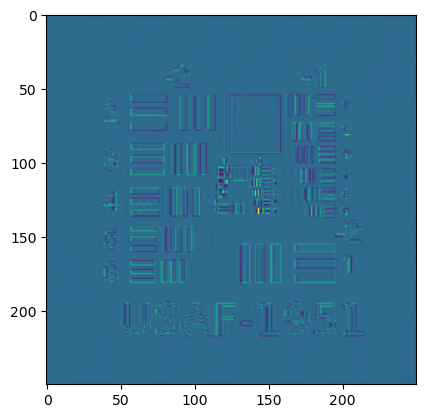

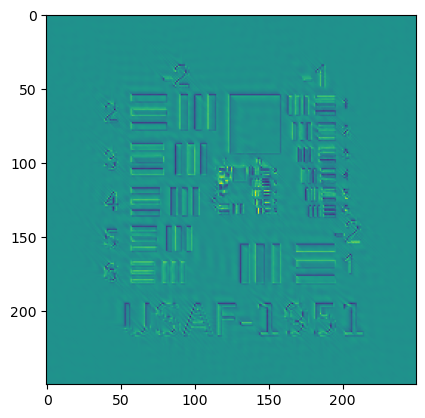

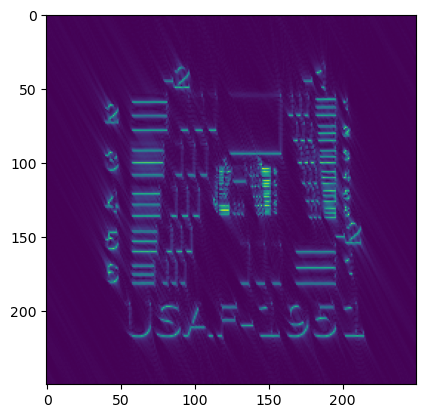

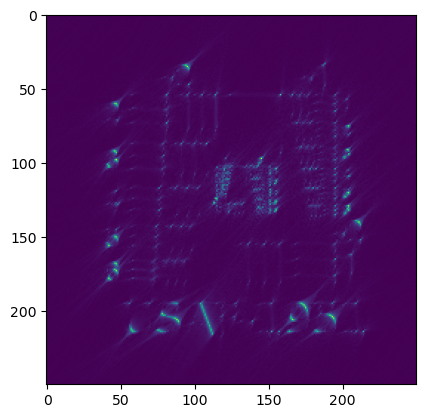

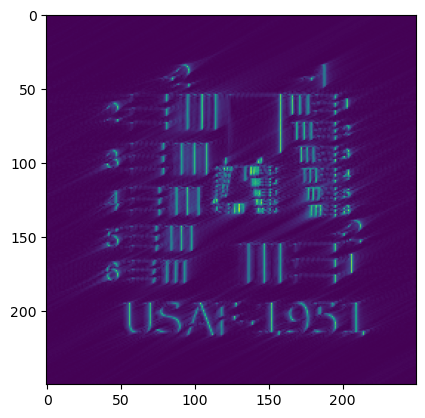

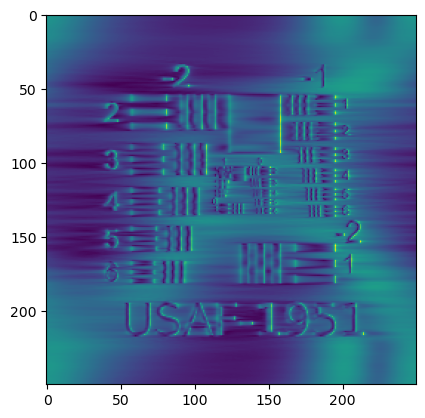

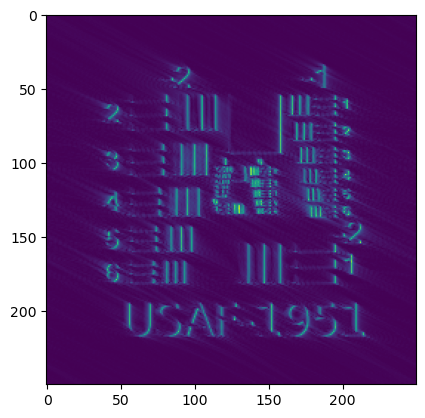

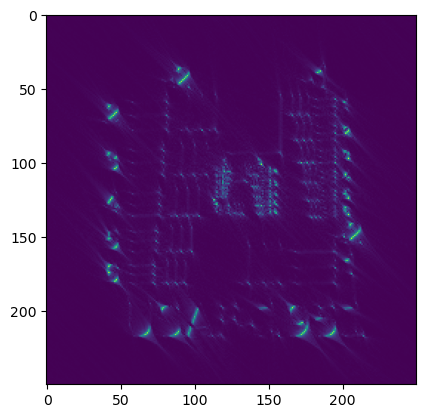

In [174]:
data = []
with torch.no_grad():
    for i in range(-2, 2+1, 1):
        for j in range(-2, 2+1, 1):
        # j=3
            U0 = source(i, j)
            Ur = propagate(U0, TR)
            plt.figure()
            plt.imshow(torch.abs(Ur).cpu()[::10, ::10])
            data.append((U0, torch.randn((N, N)).cuda()*0.0001 + torch.abs(Ur)))
    # plt.figure()
    # plt.imshow(torch.angle(U0).cpu()[::10, ::10])

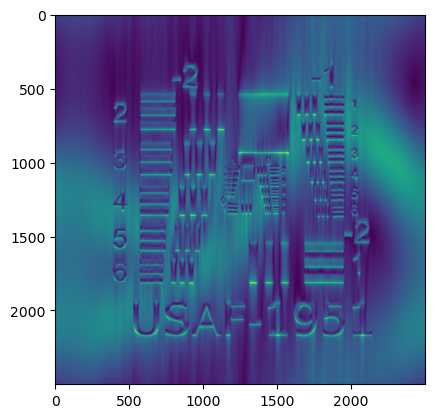

In [175]:
plt.imshow(data[14][1].cpu())

In [176]:
num_epochs = 50

import torch.optim as optim
TR_pred = (torch.ones((N, N), dtype=torch.complex64).cuda() ).requires_grad_(True)
optimizer = optim.Adam([TR_pred], lr=0.5)

In [177]:
TR_pred.shape

torch.Size([2500, 2500])

In [178]:
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # for i in range(-2, 2+1, 1):
    #     for j in range(-2, 2+1, 1):
    losses = torch.Tensor([0]).cuda()
    for U0, expUr in data:
        Ur_pred = propagate(U0, TR_pred)
        losses+= torch.mean( (torch.abs(Ur_pred) - expUr) **2)  

    
    # MSE loss between y_pred and noisy data
    # task_loss = torch.mean(torch.Tensor(losses))
    
    # Laplacian regularization
    # smooth_loss = laplacian_regularization(y_pred)
    
    # Total loss
    loss = losses
    loss.backward()
    print("loss", loss)
    
    # Backprop and step
    optimizer.step()
    

loss tensor([1.0672], device='cuda:0', grad_fn=<AddBackward0>)
loss tensor([1.4392], device='cuda:0', grad_fn=<AddBackward0>)
loss tensor([0.6729], device='cuda:0', grad_fn=<AddBackward0>)
loss tensor([1.0205], device='cuda:0', grad_fn=<AddBackward0>)
loss tensor([0.4593], device='cuda:0', grad_fn=<AddBackward0>)
loss tensor([0.4869], device='cuda:0', grad_fn=<AddBackward0>)
loss tensor([0.6035], device='cuda:0', grad_fn=<AddBackward0>)
loss tensor([0.3788], device='cuda:0', grad_fn=<AddBackward0>)
loss tensor([0.3231], device='cuda:0', grad_fn=<AddBackward0>)
loss tensor([0.4639], device='cuda:0', grad_fn=<AddBackward0>)
loss tensor([0.4268], device='cuda:0', grad_fn=<AddBackward0>)
loss tensor([0.2783], device='cuda:0', grad_fn=<AddBackward0>)
loss tensor([0.2632], device='cuda:0', grad_fn=<AddBackward0>)
loss tensor([0.3226], device='cuda:0', grad_fn=<AddBackward0>)
loss tensor([0.2874], device='cuda:0', grad_fn=<AddBackward0>)
loss tensor([0.2144], device='cuda:0', grad_fn=<AddBack

In [179]:
TR_pred_d = TR_pred.detach()

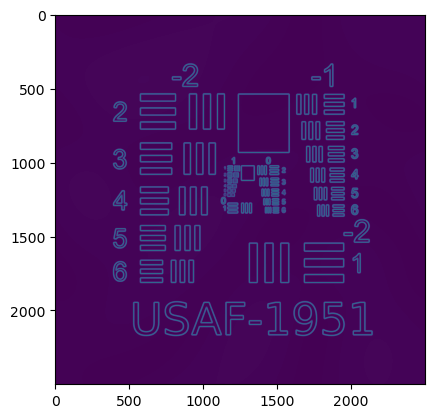

In [180]:
plt.imshow(torch.norm(tools.compute_phase_gradient(TR), dim=0).cpu(), vmin=0, vmax=1)

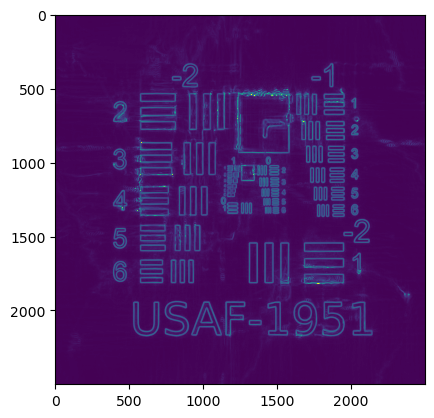

In [181]:
plt.imshow(torch.norm(tools.compute_phase_gradient(TR_pred_d), dim=0).cpu(), vmin=0, vmax=1)

In [182]:
offset = TR / TR_pred_d
offset = torch.mean(offset/torch.abs(offset))

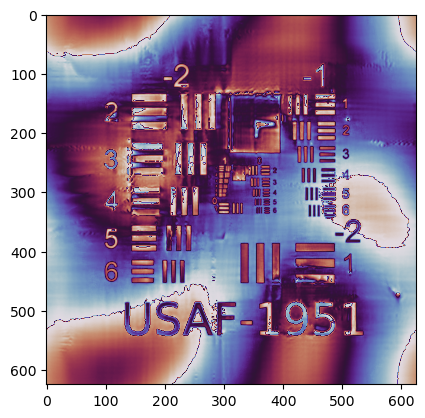

In [183]:
plt.imshow(torch.angle(TR_pred_d*offset).detach().cpu()[::4, ::4],vmin=-np.pi, vmax=np.pi,cmap="twilight")

In [184]:
# plt.imshow(torch.abs(TR_pred_d*offset).detach().cpu()[::4, ::4],vmin=0, vmax=1,cmap="gray")

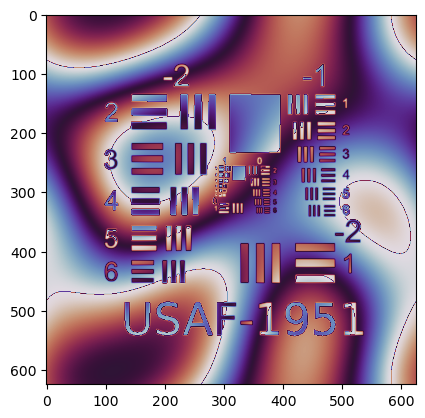

In [185]:
plt.imshow(torch.angle(TR).detach().cpu()[::4, ::4],vmin=-np.pi, vmax=np.pi,cmap="twilight")

In [29]:
U0 = source(2, 0)
Ur_pred_d = propagate(U0, TR_pred_d)
Ur_gt = propagate(U0, TR)

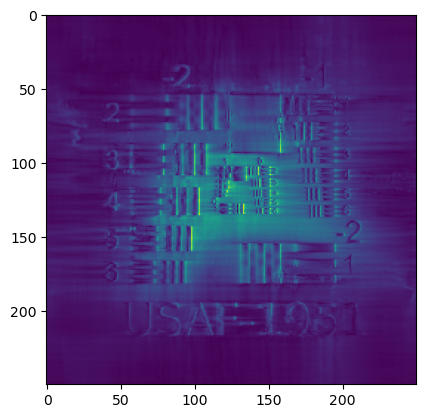

In [30]:
plt.imshow(torch.abs(Ur_pred_d).detach().cpu()[::10, ::10])

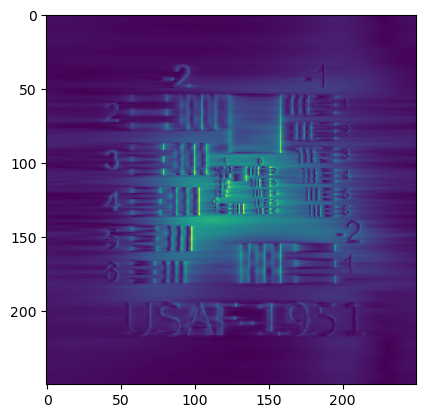

In [31]:
plt.imshow(torch.abs(Ur_gt).detach().cpu()[::10, ::10])

In [32]:
# plt.imshow(torch.abs(U0).cpu(), vmin=0, vmax=1)

In [28]:
z = 100 # mm

In [29]:
Az = A1 * torch.exp(-1j * z * torch.sqrt(k**2 - (kx**2 - ky**2)))